In [48]:
from dival.datasets.standard import get_standard_dataset
import matplotlib.pyplot as plt
import numpy as np
from skimage.transform import iradon, radon

from racts_utils import normalize_img, create_dobj, insert_dobj

# Load in data

In [49]:
dataset = get_standard_dataset('lodopab')
ray_trafo = dataset.get_ray_trafo(impl='astra_cuda')
reco_space = ray_trafo.domain
test_data = dataset.get_data_pairs('test', 1)

In [51]:
print(test_data.ground_truth[0].dtype)
print(test_data.ground_truth[0].shape)

float32
(362, 362)


In the following code, `dobj` refers to a dense object.

We'll create dobjs that have the HU of steel, which for the LoDoPaB dataset means we'll have to insert dobjs with values of 5.16.
- we're going to use random locations
- the shapes will be spherical with different radii. Since the h and w are 362, I'll set the max radius as 20 +- 10 (which I determined qualitatively after some testing)


# Sample flow

In [122]:
dobj_value = 5.16 # for steel

h ,w = test_data.ground_truth[0].shape
print("image shape:",h,w)
n_samples = w
radius = 20
spread = 10
poss_radii = np.arange(radius-spread,radius+spread+1)
get_dobj_radius = lambda  :  np.random.choice(poss_radii, size=1)[0]

# NORMALIZING IS BAD HERE; GETS RID OF RELATIVE SCALE
# raw_img = normalize_img(test_data.ground_truth[0].asarray().copy())
raw_img = test_data.ground_truth[0]

# put dobj into the img
dobj_radius = get_dobj_radius()
dobj = create_dobj(dobj_radius, irregular=False)
dobj_img = insert_dobj(raw_img.copy(), dobj, random_location=True, intensity=dobj_value)

dobj = create_dobj(dobj_radius, irregular=False)
dobj_img = insert_dobj(dobj_img, dobj, random_location=True, intensity=dobj_value)

# get sinogram of raw img
theta = np.linspace(0., 180., n_samples, endpoint=False)
circle = False
raw_sinogram = radon(raw_img, theta=theta, circle=circle)

# get sinogram of dobj img
dobj_sinogram = radon(dobj_img, theta=theta, circle=circle)

# undersample
fraction=0.2
step_size = int(1 / fraction)
indices = np.arange(0, len(theta), step_size)
theta_sampled = theta[indices]
raw_sinogram_sampled = raw_sinogram[:, indices]
dobj_sinogram_sampled = dobj_sinogram[:, indices]

# reconstruct
raw_sampled_sino_recon = iradon(raw_sinogram_sampled, theta=theta_sampled, filter_name='ramp', circle=circle)
dobj_sampled_sino_recon = iradon(dobj_sinogram_sampled, theta=theta_sampled, filter_name='ramp', circle=circle)
# clip
raw_sampled_sino_recon = np.clip(raw_sampled_sino_recon,0,1)
dobj_sampled_sino_recon = np.clip(dobj_sampled_sino_recon,0,1)

image shape: 362 362


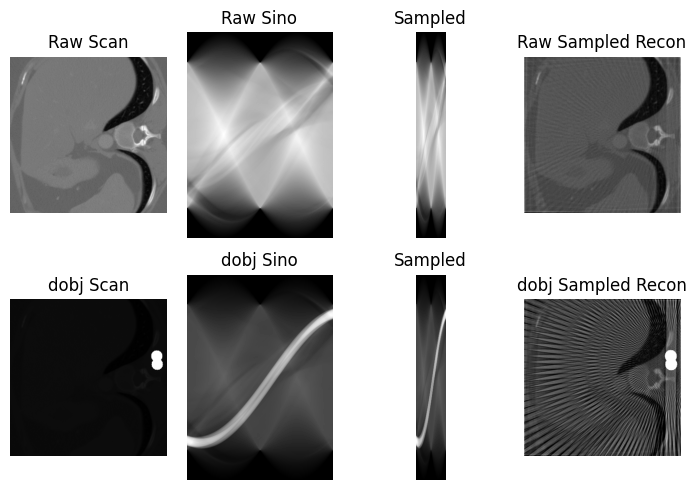

In [123]:
# Plot the imgs side by side
fig, axs = plt.subplots(2, 4, figsize=(7, 5))

axs[0,0].imshow(raw_img, cmap='gray')
axs[0,0].set_title('Raw Scan')
axs[0,0].axis('off')

axs[1,0].imshow(dobj_img, cmap='gray')
axs[1,0].set_title('dobj Scan')
axs[1,0].axis('off')

axs[0,1].imshow(raw_sinogram, cmap='gray')
axs[0,1].set_title('Raw Sino')
axs[0,1].axis('off')

axs[1,1].imshow(dobj_sinogram, cmap='gray')
axs[1,1].set_title('dobj Sino')
axs[1,1].axis('off')

axs[0,2].imshow(raw_sinogram_sampled, cmap='gray')
axs[0,2].set_title('Sampled')
axs[0,2].axis('off')

axs[1,2].imshow(dobj_sinogram_sampled, cmap='gray')
axs[1,2].set_title('Sampled')
axs[1,2].axis('off')

im = axs[0,3].imshow(raw_sampled_sino_recon, cmap='gray')
# fig.colorbar(im, ax=axs[0,3], aspect=10)
axs[0,3].set_title('Raw Sampled Recon')
axs[0,3].axis('off')

im = axs[1,3].imshow(dobj_sampled_sino_recon, cmap='gray')
# fig.colorbar(im, ax=axs[1,3], aspect=10)
axs[1,3].set_title('dobj Sampled Recon')
axs[1,3].axis('off')
plt.tight_layout()
plt.show()

# Radius testing

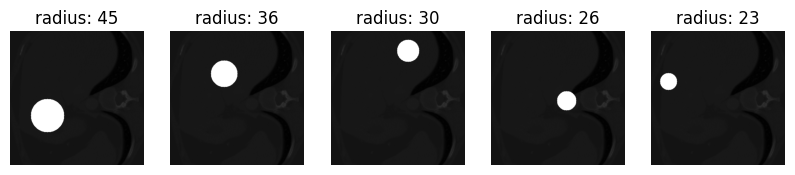

In [75]:
def plot_radii(raw_img, test_radii, dobj_value=1):
    n = len(test_radii)
    fig, axs = plt.subplots(1, n, figsize=(n*2, 4), squeeze=False)
    for i, radius in enumerate(test_radii):

        # put dobj into the img
        dobj = create_dobj(radius, irregular=False)
        dobj_img = insert_dobj(raw_img.copy(), dobj, random_location=True, intensity=dobj_value)
        axs[0,i].imshow(dobj_img, cmap='gray')
        axs[0,i].set_title('radius: {}'.format(radius))
        axs[0,i].axis('off')
    plt.show()


# plot the raw img
raw_img = normalize_img(test_data.ground_truth[0].asarray().copy())

test_radii_factors = [8,10,12,14,16]
test_radii = [np.round(h/trf).astype(int) for trf in test_radii_factors]
# Plot the imgs side by side

plot_radii(raw_img, test_radii, dobj_value=dobj_value)

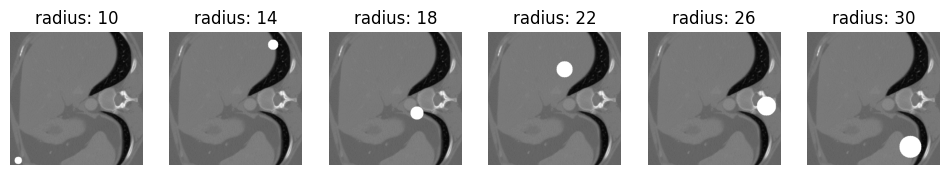

In [58]:
base_radius = 20
spread = 10 # +1

radii = [base_radius+s for s in np.arange(-spread,spread+1)][::4]
plot_radii(raw_img, radii)

# Comparing different thetas

Text(0.5, 0.98, 'Theta for radon (n_samples=const.)')

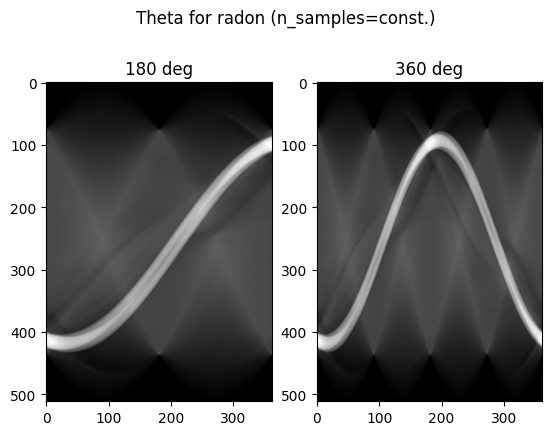

In [127]:
fig, axs = plt.subplots(1,2, squeeze=False)

# get sinogram of dobj img
theta1 = np.linspace(0., 180., n_samples, endpoint=False)
dobj_sinogram1 = radon(dobj_img, theta=theta, circle=circle)
axs[0,0].imshow(dobj_sinogram1, cmap='gray')
axs[0,0].set_title('180 deg')

theta2 = np.linspace(0., 360., n_samples, endpoint=False)
dobj_sinogram2 = radon(dobj_img, theta=theta2, circle=circle)
axs[0,1].imshow(dobj_sinogram2, cmap='gray')
axs[0,1].set_title('360 deg')

plt.suptitle('Theta for radon (n_samples=const.)')